In [3]:
from utiles.utilities import load_data

In [4]:
df = load_data("../dataset/credit_card_fraud_10k.csv")

In [5]:
df.dtypes

transaction_id           int64
amount                 float64
transaction_hour         int64
merchant_category       object
foreign_transaction      int64
location_mismatch        int64
device_trust_score       int64
velocity_last_24h        int64
cardholder_age           int64
is_fraud                 int64
dtype: object

target = 'is_fraud'
features = [col for col in df.columns if col not in target]
features

In [7]:
X = df.copy()
X.drop(['transaction_id','is_fraud'], axis=1, inplace=True)

In [8]:
y = df['is_fraud'].copy()

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: is_fraud, Length: 10000, dtype: int64

## Preprocessing pipeline

In [16]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [27]:
numeric_features = ['amount',
 'transaction_hour',
 'device_trust_score',
 'velocity_last_24h',
 'cardholder_age']
categorical_features = ['merchant_category']

In [32]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [33]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('numeric',numeric_transformer,numeric_features),
    ('category',categorical_transformer,categorical_features)
])

## CLASS IMBALANCE HANDLING USING SMOTE 
#### fraud is rare so model is likely to predict 0 (not fraud) 

In [34]:
from imblearn.over_sampling import SMOTE

## MODEL TRAINING 

### Logistic regression model

In [35]:
from sklearn.linear_model import LogisticRegression

log_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor) , 
    ('smote', SMOTE(random_state=42)),
    ('model',LogisticRegression(
        max_iter=1000, 
    ))
])

log_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount', 'transaction_hour',
                                                   'device_trust_score',
                                                   'velocity_last_24h',
                                                   'cardholder_age']),
                                                 ('category',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['merchant_category'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=1000))])

### Random forest model

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor), 
    ('model',RandomForestClassifier())
])

rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount', 'transaction_hour',
                                                   'device_trust_score',
                                                   'velocity_last_24h',
                                                   'cardholder_age']),
                                                 ('category',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['merchant_category'])])),
                ('model', RandomForestClassifier())])

### MODEL EVALUATION

In [40]:
from sklearn.metrics import classification_report , roc_auc_score, average_precision_score

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "recall": classification_report(y_test, y_pred, output_dict=True)["1"]["recall"],
        "precision": classification_report(y_test, y_pred, output_dict=True)["1"]["precision"],
        "f1": classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"],
        "roc_auc": roc_auc_score(y_test, y_prob),
        "pr_auc": average_precision_score(y_test, y_prob)
    }

In [45]:
rf_metrics = evaluate(rf_pipe, X_test, y_test)
lr_metrics = evaluate(log_pipe, X_test, y_test)

print("Random Forest:", rf_metrics)
print(f"\n \n")
print("Logistic Regression:", lr_metrics)


Random Forest: {'recall': 0.2, 'precision': 1.0, 'f1': 0.33333333333333337, 'roc_auc': 0.9035363790186126, 'pr_auc': 0.3804686367040137}

 

Logistic Regression: {'recall': 0.8, 'precision': 0.07973421926910298, 'f1': 0.14501510574018125, 'roc_auc': 0.9228426395939087, 'pr_auc': 0.26189704896049565}


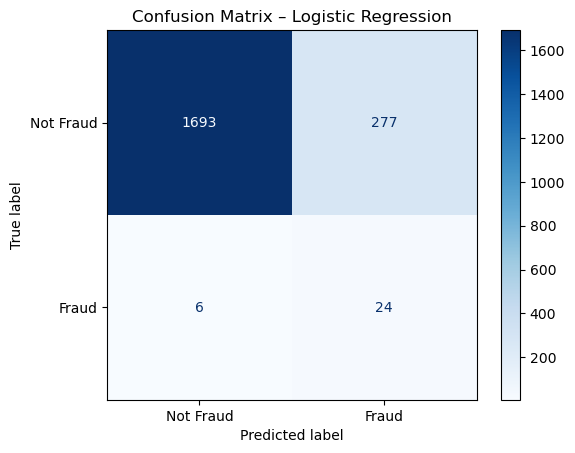

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = log_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Fraud", "Fraud"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

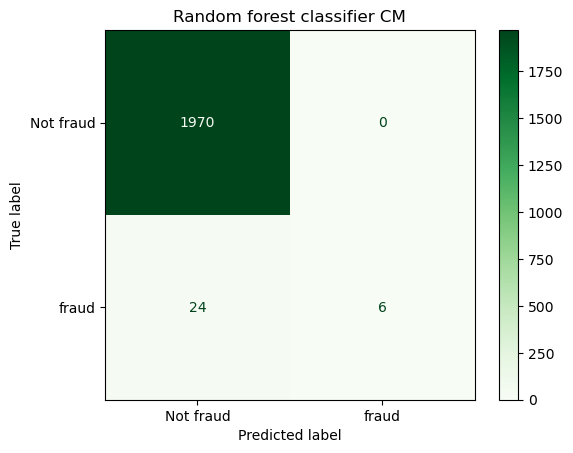

In [52]:
y_pred = rf_pipe.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not fraud","fraud"]
)
cm_display.plot(cmap="Greens")
plt.title("Random forest classifier CM")
plt.show()

## Interpretation and conclusion : Logistic Regression achieved higher recall (0.8) and ROC-AUC (0.92), making it more suitable for fraud detection where missed fraud is much more expensive and critical than having a not fraud predicted as fraud (false alarm). Random Forest showed perfect precision but low recall, indicating overly conservative behavior. Therefore, Logistic Regression was selected